In [937]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [938]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [939]:
import csv

In [940]:
data = []
atributes = []
labels = []

LABEL_INDEX = 1

with open('SVMtrain.csv', 'r', newline='') as file:
    reader = csv.reader(file)
    for index, line in enumerate(reader):
        if index == 0:
            continue
        else:
            if (line[LABEL_INDEX] not in labels):
                labels.append(line[LABEL_INDEX])
            data.append(line)


In [941]:
data_types = []

def determine_type(value):
    try:
        float(value)
        return 'Float'
    except ValueError:
        return 'Nominal'

In [942]:
for value in data[0]:
    data_types.append(determine_type(value))

In [943]:
for index, type in enumerate(data_types):
    if (type == 'Nominal'):
        unique_values = list(set(row[index] for row in data))
        if index == LABEL_INDEX:
            labels = [str(unique_values.index(label)) for label in labels]
        for row in data:
            row[index] = str(unique_values.index(row[index]))

In [944]:
data[0], data[0][2], data[0][:2] + data[0][2+1:]

(['1', '0', '3', '1', '22', '1', '0', '7.25', '3'],
 '3',
 ['1', '0', '1', '22', '1', '0', '7.25', '3'])

In [945]:
y = []
X = []
for line in data:
    y.append(labels.index(line[LABEL_INDEX]))
    X.append([float(s) for s in (line[:LABEL_INDEX]+line[LABEL_INDEX+1:])]) 

In [946]:
y = torch.tensor(y)
X = torch.tensor(X)

In [947]:
RANDOM_SEED = 42

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [948]:
X_tr = X_tr.to(device)
X_te = X_te.to(device)
y_tr = y_tr.to(device)
y_te = y_te.to(device)

In [949]:
X_tr[0]

tensor([709.0000,   1.0000,   0.0000,  22.0000,   0.0000,   0.0000, 151.5500,
          3.0000], device='cuda:0')

In [950]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=len(X_tr[0]), out_features=10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Dropout(p=0.02),
            nn.Linear(in_features=10, out_features=len(labels)),
        )

    def forward(self, x):
        return self.layer_stack(x)


In [951]:
model = Model().to(device)
model

Model(
  (layer_stack): Sequential(
    (0): Linear(in_features=8, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.02, inplace=False)
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [952]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [953]:
def accuracy_fn(y_pred, y_target):
    correct = torch.eq(y_pred, y_target).sum().item()

    return (correct/len(y_pred))*100

In [954]:
torch.manual_seed(42)

i_count = []
train_loss_values, test_loss_values = [], []
iterations = 200


for i in range(iterations):
    model.train()

    logits = model(X_tr)
    logits_pred = torch.softmax(logits, dim=1).argmax(dim=1)

    acc = accuracy_fn(y_target=y_tr, y_pred=logits_pred)
    loss = loss_fn(logits, y_tr)
    train_loss_values.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    i_count.append(i)

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_te)
        test_logits_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_te)
        test_loss_values.append(test_loss.item())
        test_acc = accuracy_fn(y_target=y_te, y_pred=test_logits_pred)

    if (i) % 20 == 0:
        print(f'Iteration {i}: TRAIN LOSS: {loss:.5f} | TRAIN ACCURACY: {acc:.1f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.1f}%')

print(f'Iteration {i+1}: TRAIN LOSS: {loss:.5f} | TRAIN ACCURACY: {acc:.2f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.2f}%')

Iteration 0: TRAIN LOSS: 0.69980 | TRAIN ACCURACY: 61.9% | TEST_LOSS: 1.53038 | TEST ACCURACY: 61.2%
Iteration 20: TRAIN LOSS: 0.66025 | TRAIN ACCURACY: 62.7% | TEST_LOSS: 0.65754 | TEST ACCURACY: 62.4%
Iteration 40: TRAIN LOSS: 0.63539 | TRAIN ACCURACY: 64.6% | TEST_LOSS: 0.64358 | TEST ACCURACY: 62.4%
Iteration 60: TRAIN LOSS: 0.61429 | TRAIN ACCURACY: 67.5% | TEST_LOSS: 0.63162 | TEST ACCURACY: 65.2%
Iteration 80: TRAIN LOSS: 0.60737 | TRAIN ACCURACY: 68.2% | TEST_LOSS: 0.60841 | TEST ACCURACY: 67.4%
Iteration 100: TRAIN LOSS: 0.60425 | TRAIN ACCURACY: 68.9% | TEST_LOSS: 0.59637 | TEST ACCURACY: 69.1%
Iteration 120: TRAIN LOSS: 0.59721 | TRAIN ACCURACY: 68.8% | TEST_LOSS: 0.59144 | TEST ACCURACY: 70.2%
Iteration 140: TRAIN LOSS: 0.58960 | TRAIN ACCURACY: 70.2% | TEST_LOSS: 0.58344 | TEST ACCURACY: 70.8%
Iteration 160: TRAIN LOSS: 0.54767 | TRAIN ACCURACY: 73.8% | TEST_LOSS: 0.59841 | TEST ACCURACY: 71.3%
Iteration 180: TRAIN LOSS: 0.49422 | TRAIN ACCURACY: 76.7% | TEST_LOSS: 0.53737

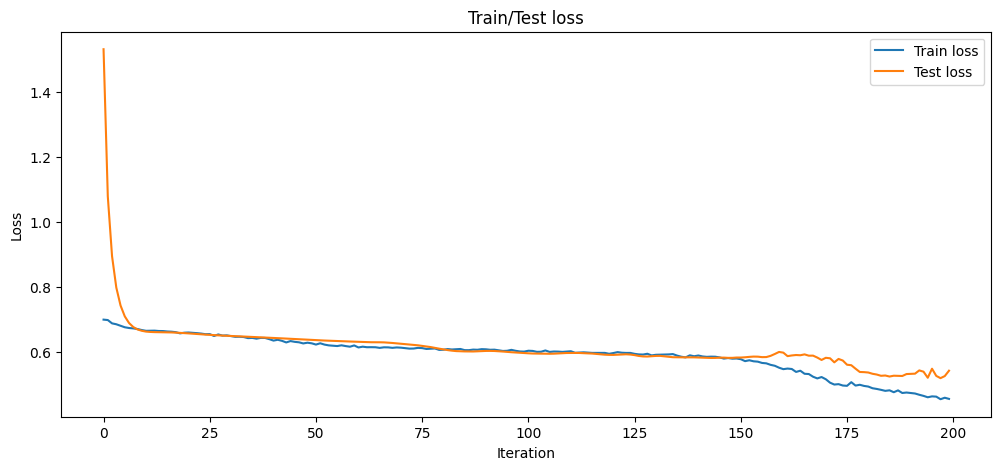

In [955]:
plt.figure(figsize=(12,5))
plt.plot(i_count, train_loss_values, label='Train loss')
plt.plot(i_count, test_loss_values, label='Test loss')
plt.title("Train/Test loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend()